## Test pertinence analyse longitudinale exports sel et eau de vie
* trend de 1750 à 1789
* comparaison entre 1750 et 1789

Je veux pouvoir :
- pour le sel distinguer celui qui sort du bureau de Marennes / autres bureaux de la DFLR / reste de la France
- pour l'eau-de-vie distinguer celle qui sort du bureau de Charente / autres bureaux de la DFLR

#### Données utilisées : Toflit (je voulais tenter avec Navigo aussi au départ mais les données ne sont pas pertinentes pour 1750 )
* produits regardés : product_revolutionempire = 'Sel' / 'Eaux-de-vie et liqueurs' (en réalité on pourrait affiner en enlevant quelques produits dans cette catégorie, et en ajoutant les produits 'vin et eau-de-vie' et 'vin et eau-de-vie' de la catégorie RE 'Boissons diverses et mélangées')

### resultats : on n'a que les données par direction pour 89 si j'ai bien compris on ne peut que comparer DFLR / reste France

In [3]:
from poitousprint import Toflit, Portic, get_pointcalls_commodity_purposes_as_toflit_product
from vega import VegaLite
import pandas as pd

toflit_client = Toflit()
portic_client = Portic()

In [17]:
flows_marennes_export_salt = toflit_client.get_flows(
    customs_office = 'Marennes', # peut être qu'on oublie des flows qui ne sont pas associés à un bureau en particulier, mais font bien partie de la DFLR
    start_year = 1750,
    end_year = 1789,
    export_import = 'Exports',
    product_revolutionempire = 'Sel')

In [18]:
flows_dflr_export_salt = toflit_client.get_flows(
    customs_region = 'La Rochelle',
    start_year = 1750,
    end_year = 1789,
    export_import = 'Exports',
    product_revolutionempire = 'Sel')

In [19]:
flows_national_export_salt = toflit_client.get_flows(
    start_year = 1750,
    end_year = 1789,
    export_import = 'Exports',
    product_revolutionempire = 'Sel')

In [21]:
print("Nombre d'exports de sel au niveau national entre 1750 et 1789  :", len(flows_national_export_salt))
print("Parmi ces exports, ", len(flows_dflr_export_salt)," sortent de la Direction des Fermes de La Rochelle, et ", len(flows_marennes_export_salt)," du bureau des Fermes de Marennes (pertinent uniquement en 89 pour ce bureau)")

Nombre d'exports de sel en au niveau national entre 1750 et 1789  : 1129
Parmi ces exports,  279  sortent de la Direction des Fermes de La Rochelle, et  14  du bureau des Fermes de Marennes


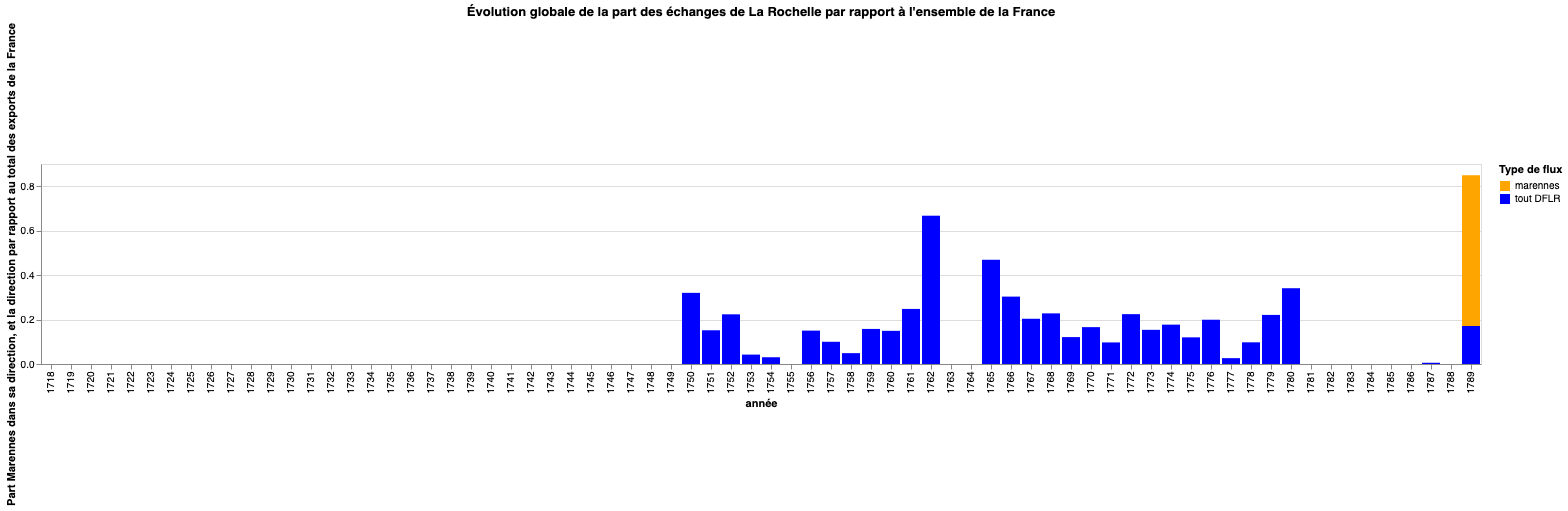

In [50]:
years_list = [y + 1712 for y in range(120)]
years = {}
nb_no_custom_office_flow_1789 = 0

for y in years_list:
    years[str(y)] = {
        "year": y,
        "france_export":0,
        "dflr_export": 0,
        "marennes_export": 0
    }


for f in flows_national_export_salt: 
    year = str(f['year'].split('.')[0])
    value = float(f['value']) if f['value'] != '' else 0
    years[year]['france_export'] += value        
    if f['customs_region'] == 'La Rochelle':
        years[year]['dflr_export'] += value
        if f['customs_office'] == 'Marennes':
            years[year]['marennes_export'] += value
        elif f['customs_office'] == '' and year == 1789:
            nb_no_custom_office_flow_1789 += 1

part_by_year = []
for year, values in years.items():
    part_by_year.append({
        "year": year,
        "type": "tout DFLR",
        "portion": values['dflr_export'] / values['france_export'] if  values['france_export'] > 0 else 0
    })
    part_by_year.append({
        "year": year,
        "type": "marennes",
        "portion": values['marennes_export'] / values['dflr_export'] if  values['dflr_export'] > 0 else 0
    })
    """

    part_by_year.append({
        "year": year,
        "type": "reste de la France",
        "portion": 1 - values['la_rochelle_total'] / values['france_total'] if  values['france_total'] > 0 else 0
    })
    """
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Évolution globale de la part des échanges de La Rochelle par rapport à l'ensemble de la France",
    "mark": {"type": "bar", "tooltip": {"content": "data"}},
    "encoding": {
        "x": {
            "field": "year",
            "type": "ordinal", 
            "title": "année"
        },
        "y": {
            "type": "quantitative",
            "field": "portion",
            "title": "Part Marennes dans sa direction, et la direction par rapport au total des exports de la France"
        },
        "color": {
            "type": "nominal",
            "field": "type",
            "title": "Type de flux",
            "scale": {
                "range": ["orange", "blue", "white"]
            }
        }
    }
}, pd.DataFrame([y for y in part_by_year if int(y['year']) > 1717 and int(y['year']) < 1790]))

In [51]:
print("Le nombre d'exports de sel rattachés à la DFLR, mais pas à un bureau particulier s'élève à ", nb_no_custom_office_flow_1789)

Le nombre d'exports de sel rattachés à la DFLR, mais pas à un bureau particulier s'élève à  0


In [24]:
flows_national_export_edv = toflit_client.get_flows(
    start_year = 1750,
    end_year = 1789,
    export_import = 'Exports',
    product_revolutionempire = 'Eaux-de-vie et liqueurs')

In [25]:
print("Nombre d'exports d'eau de vie au niveau national entre 1750 et 1789  :", len(flows_national_export_edv))

Nombre d'exports d'eau de vie au niveau national entre 1750 et 1789  : 4573


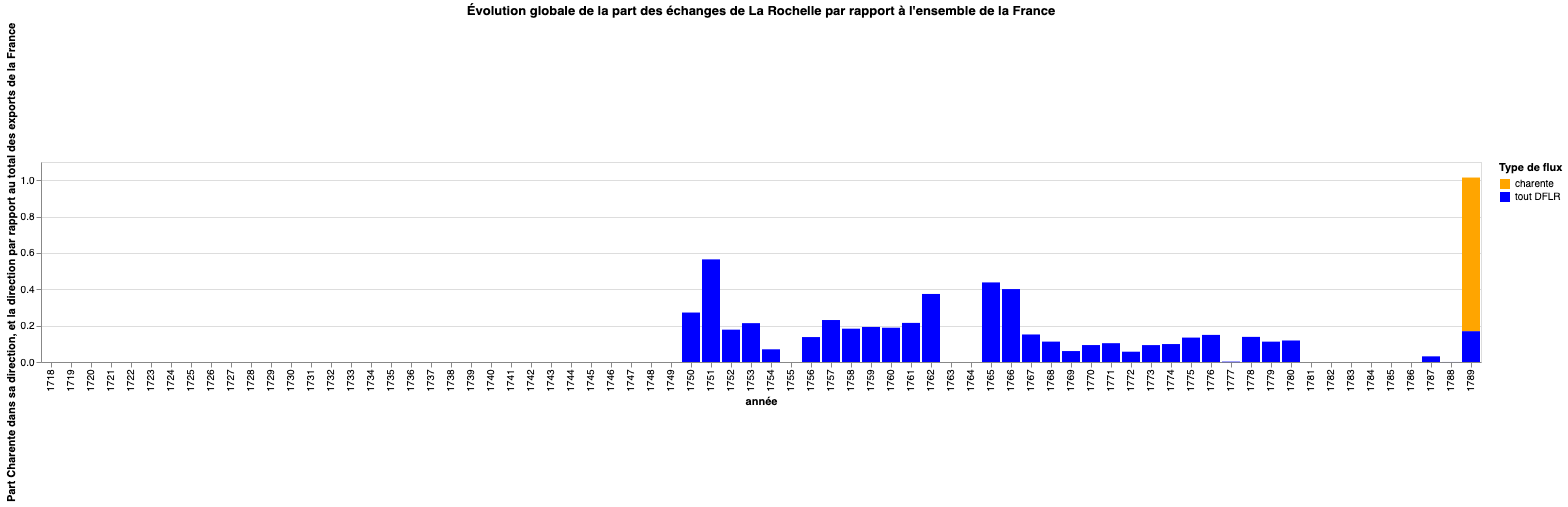

In [58]:
years_list = [y + 1712 for y in range(120)]
years = {}
nb_no_custom_office_flow_1789 = 0
customs_offices = set()

for y in years_list:
    years[str(y)] = {
        "year": y,
        "france_export":0,
        "dflr_export": 0,
        "charente_export": 0
    }


for f in flows_national_export_edv: 
    year = str(f['year'].split('.')[0])
    value = float(f['value']) if f['value'] != '' else 0
    years[year]['france_export'] += value  
    if f['customs_region'] == 'La Rochelle':
        years[year]['dflr_export'] += value
        customs_offices.add(f['customs_office'])
        if f['customs_office'] == 'Charente':
            years[year]['charente_export'] += value
        elif f['customs_office'] == '' and year == 1789:
            nb_no_custom_office_flow_1789 += 1

part_by_year = []
for year, values in years.items():
    part_by_year.append({
        "year": year,
        "type": "tout DFLR",
        "portion": values['dflr_export'] / values['france_export'] if  values['france_export'] > 0 else 0
    })
    part_by_year.append({
        "year":year,
        "type": "charente",
        "portion": values['charente_export'] / values['dflr_export'] if  values['dflr_export'] > 0 else 0
    })
    """

    part_by_year.append({
        "year": year,
        "type": "reste de la France",
        "portion": 1 - values['la_rochelle_total'] / values['france_total'] if  values['france_total'] > 0 else 0
    })
    """
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Évolution globale de la part des échanges de La Rochelle par rapport à l'ensemble de la France",
    "mark": {"type": "bar", "tooltip": {"content": "data"}},
    "encoding": {
        "x": {
            "field": "year",
            "type": "ordinal", 
            "title": "année"
        },
        "y": {
            "type": "quantitative",
            "field": "portion",
            "title": "Part Charente dans sa direction, et la direction par rapport au total des exports de la France"
        },
        "color": {
            "type": "nominal",
            "field": "type",
            "title": "Type de flux",
            "scale": {
                "range": ["orange", "blue", "white"]
            }
        }
    }
}, pd.DataFrame([y for y in part_by_year if int(y['year']) > 1717 and int(y['year']) < 1790]))


In [49]:
print("Le nombre d'exports de d'eau de vie rattachés à la DFLR, mais pas à un bureau particulier s'élève à ", nb_no_custom_office_flow_1789)

Le nombre d'exports de d'eau de vie rattachés à la DFLR, mais pas à un bureau particulier s'élève à  0
Les bureaux concernés sont :  {'', 'Saint-Martin-de-Ré', 'Rochefort', 'La Rochelle', 'Charente', 'Marennes'}


### Archive de mes tentatives avec Navigo (on a beaucoup plus de données pour 1789, mais rien pour 1750)

In [4]:
pointcalls_poitou_1789_out = portic_client.get_pointcalls(
    source_subset = 'Poitou_1789',
    ## besoin de filtrer sur les amirautés pertinentes (celles conservées dans source subset 1789)
    start_year = '1750',
    end_year = '1789',
    pointcall_action = 'Out'
)

print("nombre de pointcalls out de la direction des fermes de la rochelle en 1789 :", len(pointcalls_poitou_1789_out))

nombre de pointcalls out de la direction des fermes de la rochelle en 1789 : 6695


In [8]:
pointcalls_poitou_1789_out_with_revolution_empire_products = get_pointcalls_commodity_purposes_as_toflit_product(pointcalls_poitou_1789_out, product_classification="product_revolutionempire")
# print(pointcalls_poitou_1789_out_with_revolution_empire_products[0:3])

[{'pkid': 84150, 'record_id': '00340428', 'pointcall': 'La Rochelle', 'pointcall_uhgs_id': 'A0198999', 'toponyme_fr': 'La Rochelle', 'toponyme_en': 'La Rochelle', 'latitude': '46.166667', 'longitude': '-1.15', 'pointcall_admiralty': 'La Rochelle', 'pointcall_province': 'Aunis', 'pointcall_states': '[{"1749-1815" : "France"}]', 'pointcall_substates': None, 'pointcall_states_en': '[{"1749-1815" : "France"}]', 'pointcall_substates_en': None, 'state_1789_fr': 'France', 'state_1789_en': 'France', 'substate_1789_fr': None, 'substate_1789_en': None, 'nb_conges_1787_inputdone': 1221.0, 'nb_conges_1787_cr': None, 'nb_conges_1789_inputdone': 1060.0, 'nb_conges_1789_cr': None, 'pointcall_status_uncertainity': 0.0, 'pointcall_status': 'siège amirauté', 'shiparea': 'ACE-ROCH', 'pointcall_point': '0101000020110F000054C16EA11641FFC0ACD86784FE265641', 'ferme_direction': 'La Rochelle', 'ferme_bureau': 'La Rochelle', 'ferme_bureau_uncertainty': 0.0, 'partner_balance_1789': None, 'partner_balance_supp_17

In [12]:
# filtrer les pointcalls pour lesquels la cargaison contient du sel
pointcalls_poitou_1789_out_with_salt = []
number_of_pointcalls_from_marennes = 0

for pointcall in pointcalls_poitou_1789_out_with_revolution_empire_products:
    for commodity_purpose in pointcall['commodity_purposes']:
        if (commodity_purpose['commodity_as_toflit'] == 'Sel'):
            pointcalls_poitou_1789_out_with_salt.append(pointcall)
            if pointcall['ferme_bureau'] == 'Marennes':
                number_of_pointcalls_from_marennes += 1
        
print("Nombre de pointcalls pertinents trouvés ('Out' du Poitou en 1789 et transportant du sel) :", len(pointcalls_poitou_1789_out_with_salt))
print("Parmi ces pointcalls, ", number_of_pointcalls_from_marennes," sortent du bureau des Fermes de Marennes")

Nombre de pointcalls pertinents trouvés ('Out' du Poitou en 1789 et transportant du sel) : 2116
Parmi ces pointcalls,  1303  sortent du bureau des Fermes de Marennes
